In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
from sklearn import preprocessing
import sklearn

In [ ]:
def f(x, noise_amount):
    y = 1 + x**2*np.sin(x)*np.cos(x)
    noise = np.random.normal(0, 1, len(x))
    return y + noise_amount * noise

# dataset
def dataset(samples,features,choice = 0):
    X = np.linspace(0, 10, 100)
    y = f(X, noise_amount=1)
    X = X[:, np.newaxis]
    y = y[:, np.newaxis]
    return X,y


# plot
def plot(samples,features,choice =0 ):
    X,y = dataset(samples,features,choice)
    plt.scatter(X, y, label=r"$1 + x**2 + x**3 - x**5$", linestyle="dotted")
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    _ = plt.title("True generative process")
    
# dataset generation and splitting
def dataset_validation(X,y,split,choice = 0):
    if choice != 0:
        X = sklearn.metrics.pairwise.rbf_kernel(X, gamma = -1/2)
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    scaler1 = preprocessing.StandardScaler().fit(y)
    y = scaler1.transform(y)
    rng = np.random.RandomState(1)
    size_samples = int(split*y.size)
    training_indices = rng.choice(np.arange(y.size), size=size_samples, replace=False)
    X_train, y_train = X[training_indices], y[training_indices]
    test_indices = np.setdiff1d(np.arange(y.size),training_indices)
    X_test, y_test = X[test_indices],y[test_indices]
    return X,y,X_train,y_train,X_test,y_test

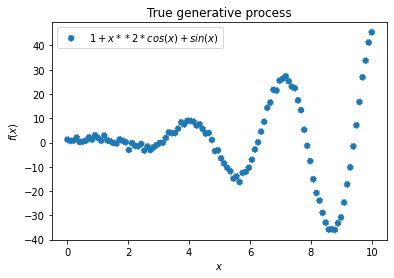

In [ ]:
# dataset
X,y = dataset(1000,2)
plot(100,2)

In [ ]:
# gaussian processes
X,y,X_train,y_train,X_test_gp,y_test_gp = dataset_validation(X,y,0.7)
# kernel = 1 * RBF(length_scale=1.0,length_scale_bounds = (1e-5,1e5)) + WhiteKernel()
kernel = RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_
print("Coefficienct of determination : ", gaussian_process.score(X_test_gp,y_test_gp))

Coefficienct of determination :  -0.0810785094356441


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [ ]:
# bayesian linear regression using kernel features
X1,y1,X_train,y_train,X_test_bl,y_test_bl = dataset_validation(X,y,0.7,1)
# can manually change the hyperparameters
#reg = linear_model.BayesianRidge(alpha_1=1e3, alpha_2=1e2, lambda_1=1e-2,lambda_2=1e3,compute_score=True)
reg = linear_model.BayesianRidge(alpha_init = 1e1,lambda_init=1e-10,compute_score=True)
print(reg)
reg.fit(X_train, y_train)
print("Coefficienct of determination : ", reg.score(X_test_bl,y_test_bl))

Coefficienct of determination :  -0.0830261586988097


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Linear regression using kernel features
X2,y2,X_train,y_train,X_test_l,y_test_l = dataset_validation(X,y,0.7,1)
regress = linear_model.LinearRegression()
regress.fit(X_train, y_train)
print("Coefficient of determination : ", reg.score(X_test_bl, y_test_bl))

Coefficient of determination :  -0.0830261586988097


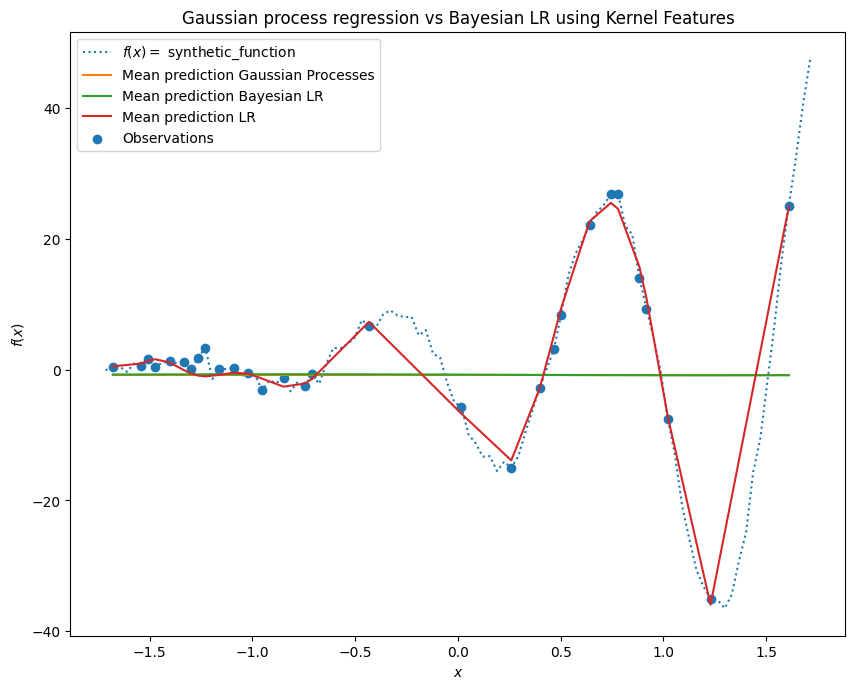

In [ ]:

# plotting both
mean_prediction_gp, std_prediction_gp = gaussian_process.predict(X_test_gp, return_std=True)
mean_prediction_bl, std_prediction_bl = reg.predict(X_test_bl, return_std=True)
mean_prediction_l = regress.predict(X_test_l)


figure(figsize=(10, 8), dpi=100)
plt.plot(X, y, label=r"$f(x) = $ synthetic_function", linestyle="dotted")
plt.scatter(X_test_gp, y_test_gp, label="Observations")
plt.plot(X_test_gp, mean_prediction_gp, label="Mean prediction Gaussian Processes")
plt.plot(X_test_gp, mean_prediction_bl, label="Mean prediction Bayesian LR")
plt.plot(X_test_gp, mean_prediction_l, label="Mean prediction LR")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression vs Bayesian LR using Kernel Features")